# Image Colorization

## Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

## Importing Data

In [2]:
count = 0
color_images = []
grayscale_images = []
for i in range(0,7129):
    
    clr_img = cv2.imread( os.path.join(os.getcwd(), "landscape Images" , "color" , str(i) + ".jpg") , 1)
    clr_img = cv2.resize( clr_img, (160,160) )
    clr_img = cv2.cvtColor(clr_img, cv2.COLOR_BGR2RGB)
    clr_img = clr_img.astype("float32") / 255.0
    color_images.append(clr_img)

    gray_img = cv2.imread( os.path.join(os.getcwd(), "landscape Images" , "gray" , str(i) + ".jpg" ) , 1)
    gray_img = cv2.resize( gray_img, (160,160) )
    gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)
    gray_img = gray_img.astype("float32") / 255.0
    grayscale_images.append(gray_img)
print(count)

0


In [26]:
def plot_image( color_image, gray_image,predicted_image = None ):
    plt.figure( figsize = ( 10 ,10 ) )
    plt.subplot( 1,3,1 )
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow( color_image )
    plt.subplot(1,3,2)
    plt.title('Grayscale Image', color = 'black', fontsize = 20)
    plt.imshow( gray_image)
    if(predicted_image is not None):
        plt.subplot(1,3,3)
        plt.title('Predicted Image', color = 'blue', fontsize = 20)
        plt.imshow( predicted_image)
            
    plt.show()

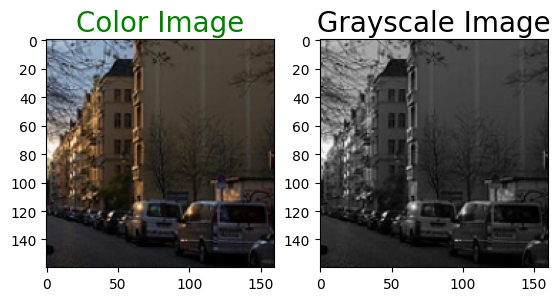

In [4]:
plot_image(color_images[0], grayscale_images[0] )

## Train-Test Split

In [5]:
x_train = grayscale_images[:6000]
x_test = grayscale_images[6000:]
y_train = color_images[:6000]
y_test = color_images[6000:]

x_train = np.reshape( x_train, (len(x_train), 160,160,3) )
x_test = np.reshape( x_test, ( len( x_test ), 160 , 160 , 3  ) )
y_train = np.reshape( y_train, ( len(y_train),160,160,3 ) )
y_test = np.reshape( y_test, ( len(y_test) , 160 , 160 , 3 ) ) 

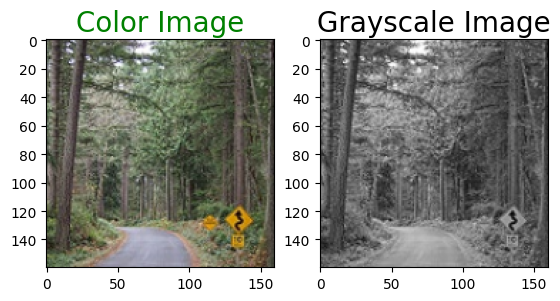

In [6]:
plot_image(y_test[0], x_test[0])

### Deep Learning model to convert grayscale images to colored images

In [11]:
def encoder_downsample_block(inputs, num_filter, kernel_size):
    x = tf.keras.layers.Conv2D(num_filter, kernel_size, padding = "same")(inputs)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(num_filter, kernel_size, padding = "same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2)(x)
    return x

In [12]:
def decoder_upsample_block(inputs,num_filters , kernel_size): #skip_features): 

	x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs) 
	# skip_features = tf.image.resize(skip_features, size = (x.shape[1], x.shape[2])) 
	# x = tf.keras.layers.Concatenate()([x, skip_features]) 
	x = tf.keras.layers.Conv2D(num_filters, kernel_size , padding = 'same')(x) 
	x = tf.keras.layers.Activation('relu')(x) 
	x = tf.keras.layers.Conv2D(num_filters, kernel_size , padding = 'same')(x) 
	x = tf.keras.layers.Activation('relu')(x) 
	
	return x


In [13]:
def model():
    input_layer = tf.keras.layers.Input(shape = (160,160,3))
    e1 = encoder_downsample_block( input_layer, 64, (3,3) )
    e2 = encoder_downsample_block( e1, 128, (3,3) )
    e3 = encoder_downsample_block( e2, 256, (3,3) )
    e4 = encoder_downsample_block( e3, 512, (3,3) )
    
    d1 = decoder_upsample_block ( e4, 512, (3,3) )
    d2 = decoder_upsample_block( d1,256, (3,3) )
    d3 = decoder_upsample_block( d2, 128, (3,3) )
    d4 = decoder_upsample_block( d3, 64, (3,3) )
    d5 = tf.keras.layers.concatenate([d4,input_layer])
    output_layer = tf.keras.layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(d5)
    return tf.keras.Model( inputs = input_layer, outputs = output_layer )

In [ ]:
class PlotLearning(keras.callbacks.Callback)
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [14]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 160, 160, 32)         896       ['input_2[0][0]']             
                                                                                                  
 activation_2 (Activation)   (None, 160, 160, 32)         0         ['conv2d_2[0][0]']            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 160, 160, 32)         9248      ['activation_2[0][0]']        
                                                                                              

In [15]:
count = 0
for i in x_train:
    if i.shape != (160,160,3):
        plot_image( i,i)
        print(i.shape)
        count = count + 1
for i in y_train:
    if i.shape != (160,160,3):
        plot_image(i,i)
        print(i.shape)
        count = count + 1
print(count)

0


In [17]:


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.mean_absolute_error,
              metrics = ['accuracy'])

model.fit(x_train, y_train, batch_size = 50, epochs = 10)



Epoch 1/50
120/120 [==============================] - 550s 4s/step - loss: 0.1236 - accuracy: 0.3608
Epoch 2/50
120/120 [==============================] - 510s 4s/step - loss: 0.0753 - accuracy: 0.3979
Epoch 3/50
120/120 [==============================] - 506s 4s/step - loss: 0.0655 - accuracy: 0.4808
Epoch 4/50
120/120 [==============================] - 508s 4s/step - loss: 0.0602 - accuracy: 0.4994
Epoch 5/50
120/120 [==============================] - 528s 4s/step - loss: 0.0568 - accuracy: 0.5070
Epoch 6/50
120/120 [==============================] - 522s 4s/step - loss: 0.0531 - accuracy: 0.5229
Epoch 7/50
120/120 [==============================] - 503s 4s/step - loss: 0.0502 - accuracy: 0.5315
Epoch 8/50
120/120 [==============================] - 515s 4s/step - loss: 0.0475 - accuracy: 0.5462
Epoch 9/50
120/120 [==============================] - 513s 4s/step - loss: 0.0458 - accuracy: 0.5547
Epoch 10/50
120/120 [==============================] - 518s 4s/step - loss: 0.0445 - accura

1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


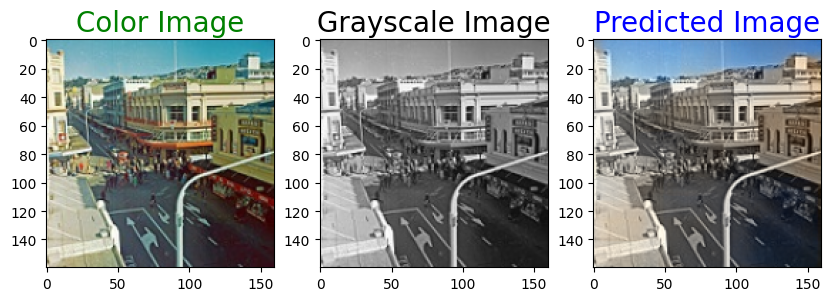

1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


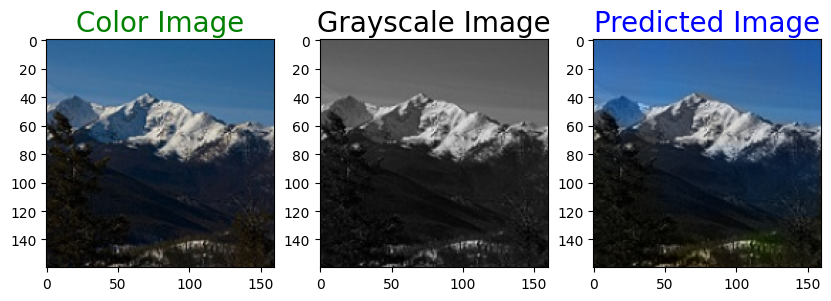

1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


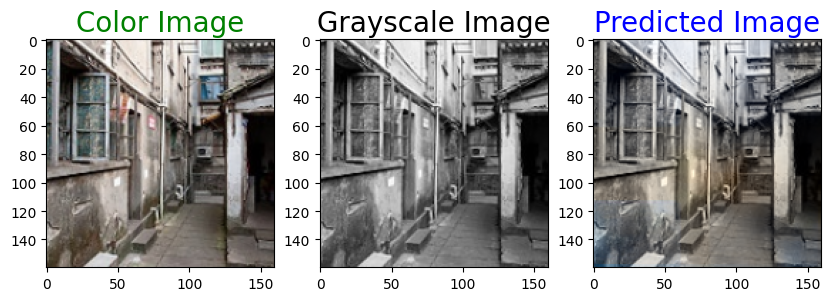

1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


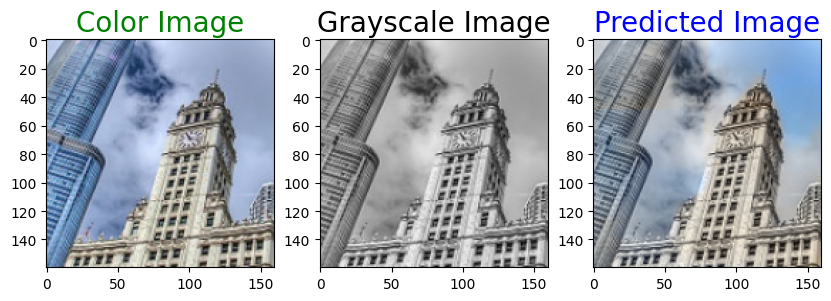

1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


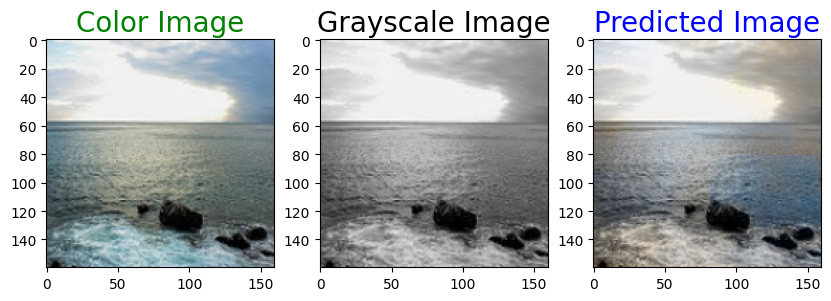

1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


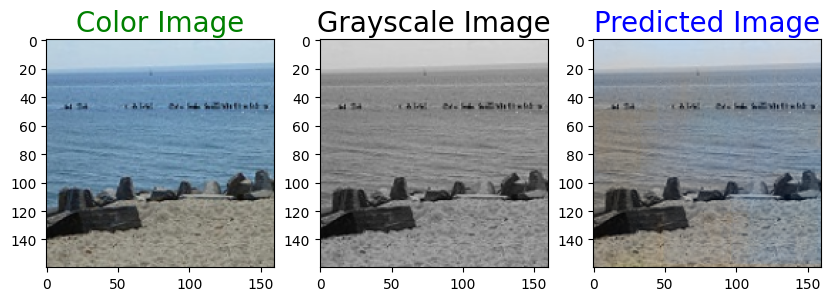

1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


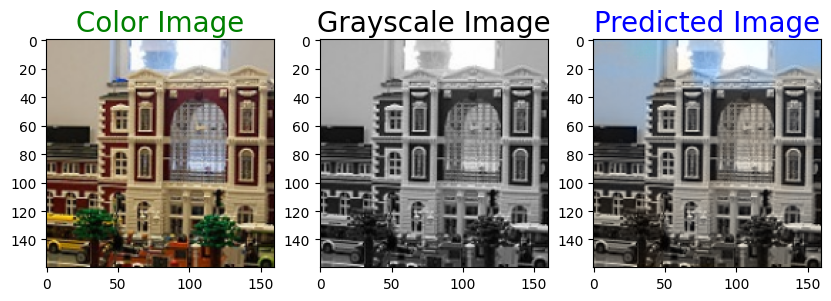

1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


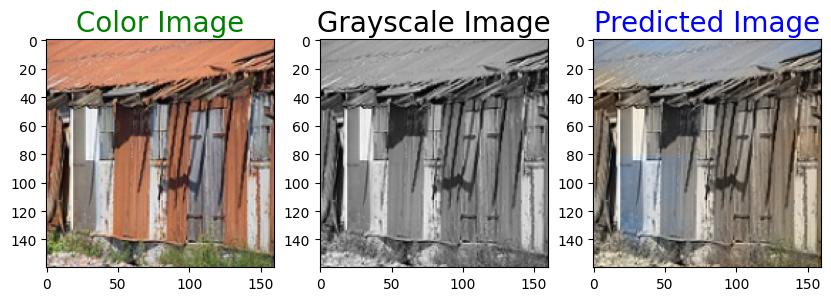

1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


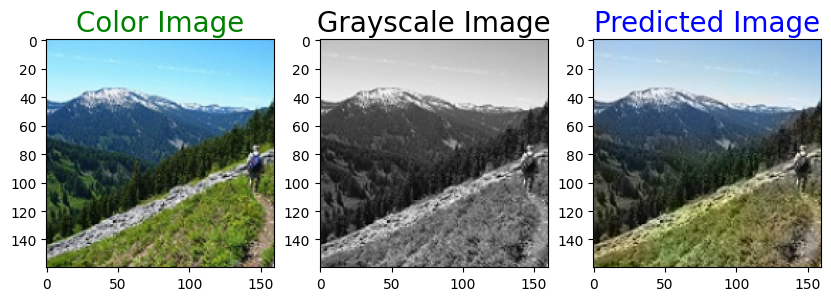

1/1 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


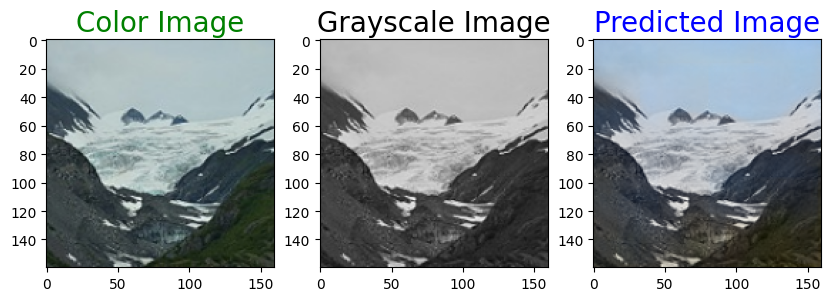

1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


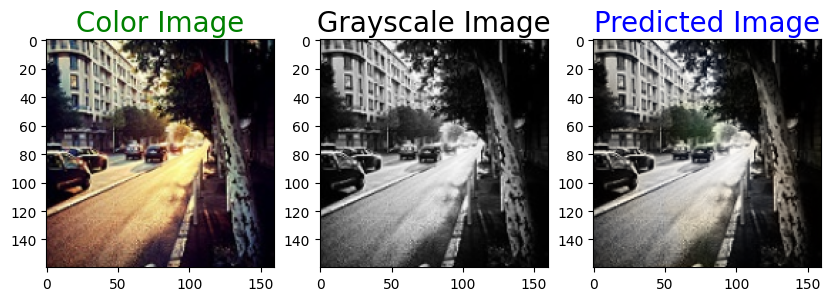

1/1 [==============================] - 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


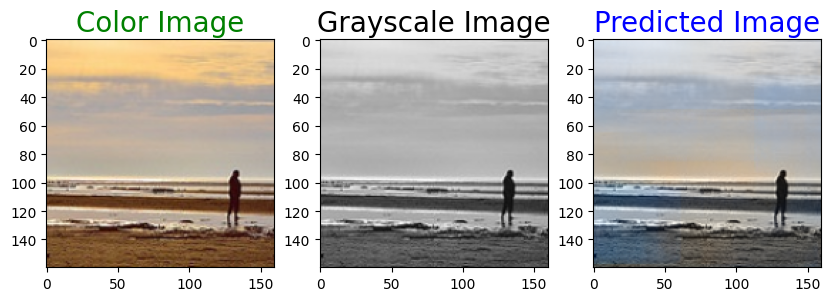

1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


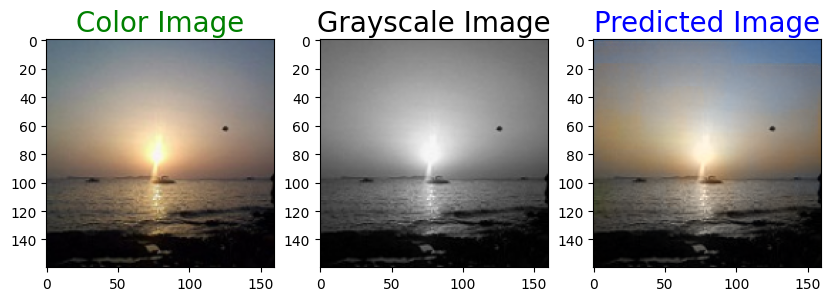

1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


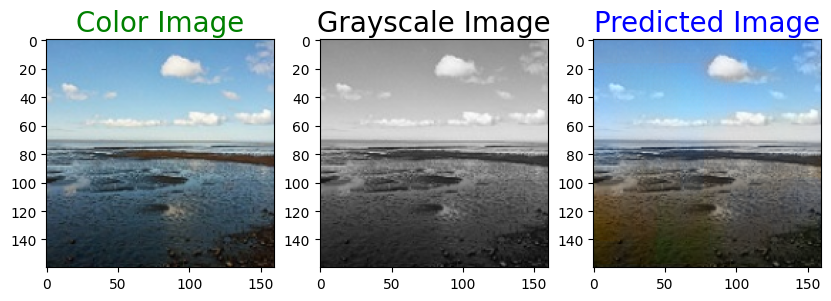

1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


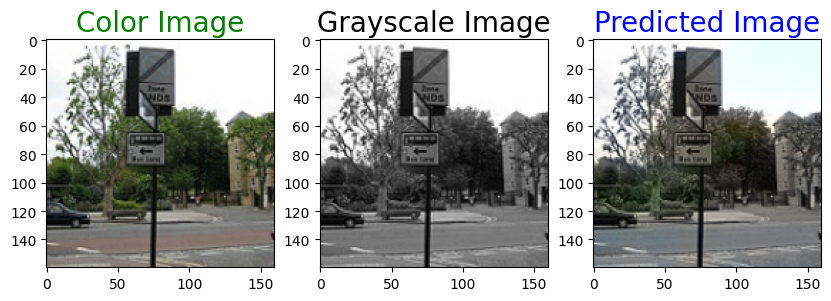

1/1 [==============================] - 0s 45ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


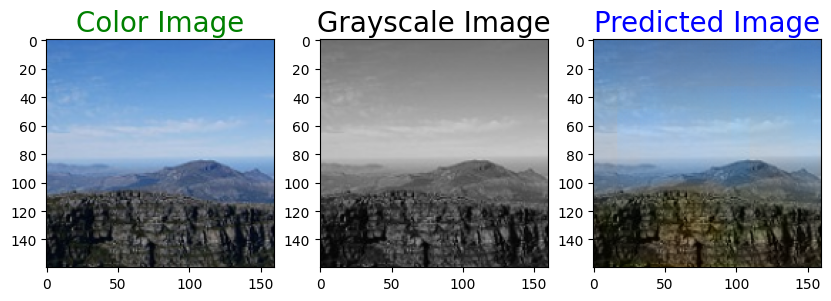

1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


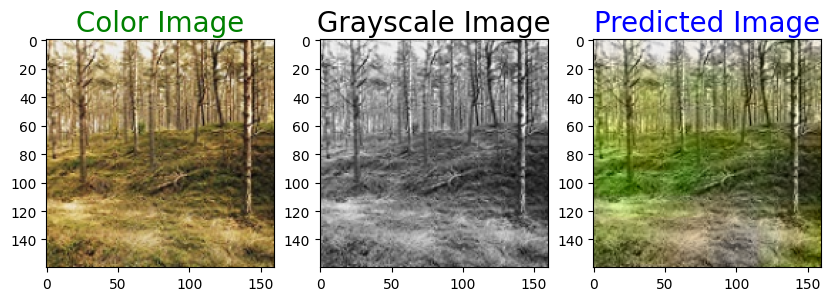

1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


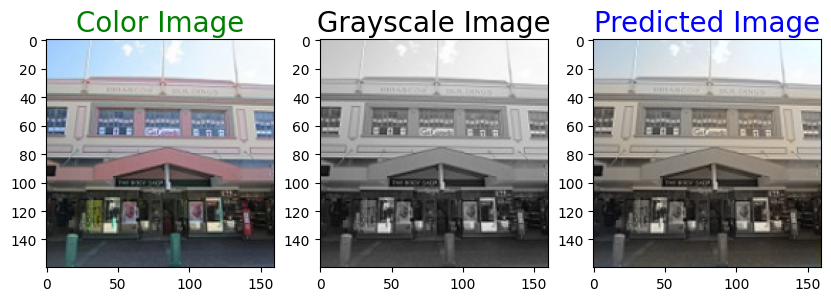

1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


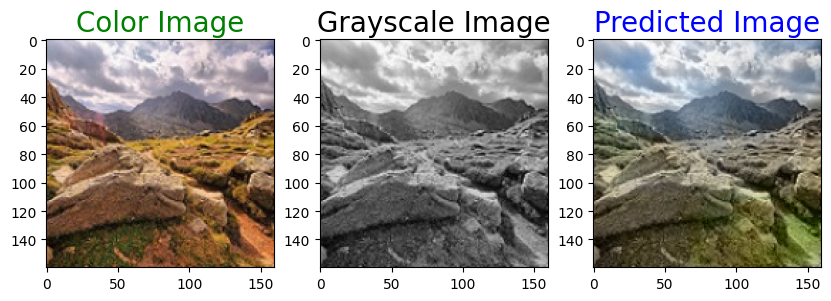

1/1 [==============================] - 0s 51ms/step


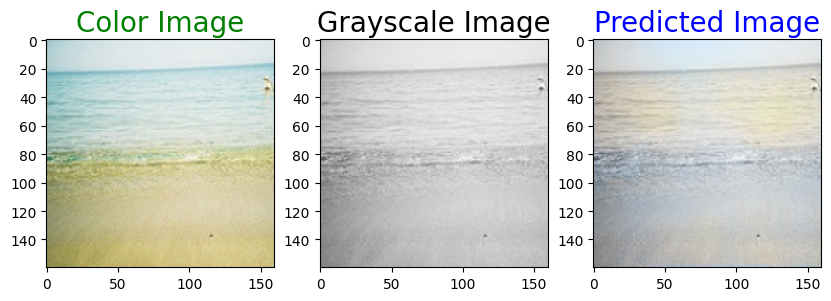

In [30]:
for i in range(20,40):
    predicted_image = np.reshape(model.predict( np.reshape(x_test[i], (1, 160, 160, 3) )), (160,160,3) )
    plot_image(y_test[i], x_test[i], predicted_image)